In [35]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )
    
    
    ! pip install geopandas

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

# modify path
fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)    
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

# compile cython routing script
COMPILE_cython = True
# ! This will definitely work in the Google Colab environment, though may not work
# in your local envioronment.
if COMPILE_cython:

    subprocess.run(
        ["gfortran", "varPrecision.f90", "-c", "-o", "var_precision.o", "-O3", "-fPIC"],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "MCsingleSegStime_f2py_NOLOOP.f90",
            "-c",
            "-o",
            "mc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )

    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])

    if ENV_IS_CL:
        numpy_I = "/usr/local/lib/python3.6/dist-packages/numpy/core/include"
        py_I = "/usr/include/python3.6"
        py_lib = "/usr/include/python3.6"

    else:
        bin_exe = pathlib.Path(sys.executable)
        virtual_env_path = bin_exe.parents[1]
        py_lib = os.path.join(virtual_env_path, "lib")
        numpy_I = os.path.join(
            py_lib, "python3.6", "dist-packages", "numpy", "core", "include"
        )
        py_I = os.path.join(virtual_env_path, "include", "python3.6m")

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "mc_reach.pyx",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-Wno-unused-result",
            "-Wsign-compare",
            "-DNDEBUG",
            "-g",
            "-fwrapv",
            "-O3",
            "-fno-strict-aliasing",
            "-Wall",
            "-Wstrict-prototypes",
            "-fPIC",
            "-I",
            numpy_I,
            "-I",
            py_I,
            "-c",
            "mc_reach.c",
            "-o",
            "mc_reach.o",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared",
            "-L",
            py_lib,
            "var_precision.o",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "mc_reach.o",
            "-lgfortran",
            "-o",
            "mc_reach.cpython-36m-x86_64-linux-gnu.so",
        ],
        cwd=routing_v02_dir,
    )

# load needed scientific libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import chain
from functools import partial

# turn off warnings
import warnings
warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import mc_reach


/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/mc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/pymc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/var_precision.o


In [79]:
def sim(rch_len, dx_base, dx_ratio):
    ################################################
    # Set-up model domain
    ################################################
    # SPACE
    L = rch_len # meters
    nsegs = round(L/dx_base)

    L1 = (2*dx_base)/(dx_ratio + 1)
    L2 = (2*dx_base) - L1
    L = [L1] + [L2]
    dx = L * round(rch_len/(2*dx_base))

    # TIME
    n_days = 6
    len_sim = n_days*(24*60*60) # seconds
    dt = 60
    nts = round(len_sim/dt)

    ################################################
    # Create model parameter set
    ################################################
    link_start = 8815967 # arbitrary linkID for the top segment of the reach
    headwaters = [8815960, 8815961] # create two headwaters, one of which will accept lateral inflows

    # construct linkIDs and destination linkIDs
    linkID = list(range(link_start,
                        link_start + nsegs,
                        1))
    linkID = headwaters + linkID

    headwater_to = [link_start, link_start]
    toID = list(range(link_start + 1,
                      link_start + nsegs,
                      1))
    toID.append(0)
    toID = headwater_to + toID

    # link-distance lookup - what is the physical distance associated with each segment? 
    link_distance = {}
    for i, link in enumerate(linkID[2:],1):
        link_distance[sum(dx[0:i])] = link

    # build parameter DataFrame
    d = {'link': linkID,
          'to': toID,
          'dx': 2*[dx_base] + dx,
          'n': [0.028] * (nsegs+2),
          'ncc': [0.031] * (nsegs+2),
          's0': [0.0018] * (nsegs+2),
          'bw': [112] * (nsegs+2),
          'tw': [448] * (nsegs+2),
          'twcc': [623] * (nsegs+2),
          'MusK': [3600.0] * (nsegs+2),
          'MusX': [0.2] * (nsegs+2),
          'cs': [1.40] * (nsegs+2)}

    df = pd.DataFrame(data=d)
    df = df.set_index('link')
    df = df.sort_index()

    # replace downstreams for terminal segments
    df = nhd_io.replace_downstreams(df, 'to', 0)

    ################################################
    # Create lateral inflow data
    ################################################
    t_pk = 2*24*(60*60)
    width = 2*(60*60)
    q_pk = 0.5 #cms
    q_baseflow = 1

    x = np.linspace(0,len_sim, round(len_sim/dt))
    y = norm.pdf(x,t_pk,width)
    y_scale = y * q_pk/max(y) + q_baseflow

    # construct lateral inflow series
    ql = pd.DataFrame(0, index=linkID, columns=range(round(len_sim/dt)),dtype=np.float64)
    ql.iloc[0,:] = y_scale

    ################################################
    # Build network
    ################################################
    conn = nhd_network.extract_connections(df, 'to')
    rconn = nhd_network.reverse_network(conn)
    subnets = nhd_network.reachable_network(rconn, check_disjoint = False)

    # identify the segments in each subnetwork
    subreachable = nhd_network.reachable(rconn)

    # break each subnetwork into reaches
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

    tail_water = max(linkID)
    reach = subreaches[tail_water]
    r = list(filter(None, chain.from_iterable(reach)))

    ################################################
    # Simulate network routing
    ################################################
    # add a dt column to the data DataFrame
    df["dt"] = dt

    # change variables to type float32, as expected by mc_reach.compute_network
    df = df.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = df.loc[
        r, ["dt", "dx", "bw", "tw", "twcc", "n", "ncc", "cs", "s0"]
    ].sort_index()

    # create qlat dataset
    qlat_sub = ql.loc[r].sort_index()

    # compute the network routing, calculate (flow, depth, and velocity)
    results = []

    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values.astype("float32"),
            assume_short_ts=False
        )
    )

    ################################################
    # re-format simulation output
    ################################################

    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()

    # identify segment ID at 10 km
    x_sample = link_distance[rch_len]

    flows = flowveldepth.loc[x_sample, (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    flows.rename(columns = {x_sample: "10-km"}, inplace = True)

    flows['Forcing'] = ql.loc[linkID[0],:].T
    flows['Time (d)'] = ((flows.Timestep + 1) * dt)/(24*60*60)
    flows = flows.set_index('Time (d)')

    flows = flows.drop(["Timestep", "Parameter"], axis=1)

    return flows, df
    

In [164]:
rch_len = 10000

dx_ratio_array = np.arange(1,100,5)
dx_base_array = [50,100,200,500,1000]

celerity = pd.DataFrame(0, index=dx_ratio_array, columns=dx_base_array,dtype=np.float64)
qpk = pd.DataFrame(0, index=dx_ratio_array, columns=dx_base_array,dtype=np.float64)
mass_rec = pd.DataFrame(0, index=dx_ratio_array, columns=dx_base_array,dtype=np.float64)

for dx_base in dx_base_array:
    
    print("working on",dx_base,"meter base length simulation")
    
    for dx_ratio in dx_ratio_array:

        # call the model simulation function
        flow, df = sim(rch_len, dx_base, dx_ratio)

        # estimate celerity by peak flow transmission times (meters per second)
        c = (-(flow.loc[:,'Forcing'].idxmax() - flow.loc[:,'10-km'].idxmax())*(24*60*60))/rch_len
        celerity.loc[dx_ratio,dx_base] = c
        
        # peak flow magnitude
        pk =  flow.loc[:,'10-km'].max()
        qpk.loc[dx_ratio,dx_base] = pk
        
        # mass_balance
        m =  flow.loc[flow.index > 1.5,'10-km'].sum()/flow.loc[flow.index > 1.5,'Forcing'].sum()
        mass_rec.loc[dx_ratio,dx_base] = m

working on 50 meter base length simulation
working on 100 meter base length simulation
working on 200 meter base length simulation
working on 500 meter base length simulation
working on 1000 meter base length simulation


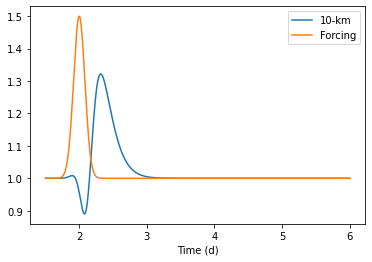

In [172]:
rch_len = 10000
dx_base = 5000
dx_ratio = 1

flow, df = sim(rch_len, dx_base, dx_ratio)


flow.loc[flow.index > 1.5].plot()